In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys

In [19]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'shortaxis_binary v2.xlsx')   #DSI_research/shortaxis_binary.xlsx
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=f'{video_folder}')
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/xxx_0.jpg
                        root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                        frame_idx = int(root.split('_')[-1]) #splitting xxx_0 and storing 0 to frame_idx
                        labels = labels_df.loc[frame_idx, ['BAD QUALITY']].values.astype('float32')#.squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')   #DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/0.jpg_xxxxx.jpg
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['BAD QUALITY']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels


def initialize_data(root_dir, sub_folder, data_type='original'):
    # Define image transformations for training and validation/test
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop((224, 224)),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    # Initialize the dataset with training transformations
    full_dataset = CustomDataset(root_dir, sub_folder=sub_folder, transform=None, data_type=data_type)

    # Define the sizes for training, validation, and test sets
    total_size = len(full_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset into training, validation, and test sets
    train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply the appropriate transformations to each subset
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_subset.dataset.transform = val_test_transform

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    print('Data Size: train:', len(train_loader.dataset), 'val:', len(val_loader.dataset), 'test:', len(test_loader.dataset))

    return train_loader, val_loader, test_loader

In [20]:
# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

In [21]:
# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})
            torch.save(model, "saved_model.pt")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the state of the model
        torch.save(model.state_dict(), "saved_model_state1.pt")
        torch.save(model, "saved_model1.pt")

        ######################### Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [22]:
# Load Model
import io

# Assuming `model_data` is a byte stream (non-seekable) from a database or similar

def load_model(model_path):
    # Load the saved model
    model = torch.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

In [52]:
# Test Model
import io
def test_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            #Check for misclassifications
            for idx, (pred, true) in enumerate(zip(predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,
                        'predicted_labels': pred.cpu().numpy(),
                        'image': images[idx].cpu().detach(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_true, y_pred)
        except:
            roc_auc = 1
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
#     for misclassified in misclassified_images:
#         print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")
# #     
#     print("here")
#     for idx, (pred, true) in enumerate(zip(predicts, labels)):
#         if not torch.equal(pred, true):
#             misclassified_images.append({
#                 'image_index': image_index + idx,
#                 'image': images[idx].cpu().detach(),  # Save the image tensor
#                 'predicted_labels': pred.cpu().numpy(),
#                 'true_labels': true.cpu().numpy()
#             })
    return all_labels, all_preds, misclassified_images

In [47]:
# Main function to run the whole pipeline
def main(root_dir, sub_folder, model, criterion, optimizer, num_epochs, data_type='original'):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder, data_type=data_type)
    #check_loaders(train_loader, val_loader, test_loader)

    '''global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model1.pt", criterion)
    
import matplotlib.pyplot as plt

def show_images(images, labels=None, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axs[i].axis('off')
        if labels is not None:
            axs[i].set_title(labels[i])

def check_loaders(train_loader, val_loader, test_loader):
    print("Train Loader: {} batches ({} images)".format(len(train_loader), len(train_loader.dataset)))
    print("Validation Loader: {} batches ({} images)".format(len(val_loader), len(val_loader.dataset)))
    print("Test Loader: {} batches ({} images)".format(len(test_loader), len(test_loader.dataset)))

    # Optionally, visualize some images from each loader
    for images, labels in train_loader:
        show_images(images)
        break  # Just show the first batch
        
#train-valid-test
def tvt(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model1.pt", criterion)
    
root_dir = '.'
sub_folder = 'short axis frames'
num_classes=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
org_train_loader, org_val_loader, org_test_loader = initialize_data(root_dir,
                                                                    sub_folder,
                                                                    data_type='original')

Processing video folder: LP SONO 001 POST FNL CONUS
Processing video folder: US00000L
Processing video folder: AM12 (Converted)
Processing video folder: 01.09.31 hrs __0025097
Processing video folder: LPPILOTLAT1
Processing video folder: XM12 (Converted)
Processing video folder: LP SONO 001 POST FST CONUS
Processing video folder: LPPILOTSITTING2
Processing video folder: YM12 (Converted)
Processing video folder: 01.09.47 hrs __0025098
Processing video folder: LPPILOTLAT3
Processing video folder: LPPILOTLAT2
Processing video folder: BM12 (Converted)
Number of videos: 13
Data Size: train: 2373 val: 339 test: 678


Epoch 1: 100%|████████████████████████████| 75/75 [00:27<00:00,  2.68it/s, Batch Loss=0.606, Batch Accuracy=0.6]


Epoch 1/15 - Loss: 0.2130, Accuracy: 0.9132
Validation:


Epoch 1: 100%|███████████████████████████| 11/11 [00:01<00:00,  6.53it/s, Batch Loss=1.58, Batch Accuracy=0.842]


Validation Epoch 1/15 - Loss: 0.8858, Accuracy: 0.8879
------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████████████████████████| 75/75 [00:26<00:00,  2.83it/s, Batch Loss=0.011, Batch Accuracy=1]


Epoch 2/15 - Loss: 0.0834, Accuracy: 0.9709
Validation:


Epoch 2: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.21it/s, Batch Loss=0.206, Batch Accuracy=0.947]


Validation Epoch 2/15 - Loss: 0.0618, Accuracy: 0.9764
------------------------------------------------------------------------------------------------


Epoch 3: 100%|█████████████████████████████| 75/75 [00:27<00:00,  2.72it/s, Batch Loss=0.0121, Batch Accuracy=1]


Epoch 3/15 - Loss: 0.0534, Accuracy: 0.9798
Validation:


Epoch 3: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.51it/s, Batch Loss=0.454, Batch Accuracy=0.789]


Validation Epoch 3/15 - Loss: 0.2361, Accuracy: 0.9263
------------------------------------------------------------------------------------------------


Epoch 4: 100%|█████████████████████████████| 75/75 [00:26<00:00,  2.81it/s, Batch Loss=0.0161, Batch Accuracy=1]


Epoch 4/15 - Loss: 0.0467, Accuracy: 0.9823
Validation:


Epoch 4: 100%|███████████████████████████| 11/11 [00:01<00:00,  6.53it/s, Batch Loss=0.41, Batch Accuracy=0.895]


Validation Epoch 4/15 - Loss: 0.0672, Accuracy: 0.9764
------------------------------------------------------------------------------------------------


Epoch 5: 100%|██████████████████████████████| 75/75 [00:27<00:00,  2.71it/s, Batch Loss=1.1, Batch Accuracy=0.8]


Epoch 5/15 - Loss: 0.0250, Accuracy: 0.9924
Validation:


Epoch 5: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.46it/s, Batch Loss=0.171, Batch Accuracy=0.895]


Validation Epoch 5/15 - Loss: 0.1111, Accuracy: 0.9499
------------------------------------------------------------------------------------------------


Epoch 6: 100%|████████████████████████████| 75/75 [00:26<00:00,  2.82it/s, Batch Loss=0.348, Batch Accuracy=0.8]


Epoch 6/15 - Loss: 0.0589, Accuracy: 0.9772
Validation:


Epoch 6: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.43it/s, Batch Loss=0.216, Batch Accuracy=0.895]


Validation Epoch 6/15 - Loss: 0.0681, Accuracy: 0.9764
------------------------------------------------------------------------------------------------


Epoch 7: 100%|████████████████████████████| 75/75 [00:27<00:00,  2.71it/s, Batch Loss=0.00854, Batch Accuracy=1]


Epoch 7/15 - Loss: 0.0581, Accuracy: 0.9777
Validation:


Epoch 7: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.53it/s, Batch Loss=0.216, Batch Accuracy=0.947]


Validation Epoch 7/15 - Loss: 0.0594, Accuracy: 0.9794
------------------------------------------------------------------------------------------------


Epoch 8: 100%|█████████████████████████████| 75/75 [00:26<00:00,  2.81it/s, Batch Loss=0.0155, Batch Accuracy=1]


Epoch 8/15 - Loss: 0.0309, Accuracy: 0.9899
Validation:


Epoch 8: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.48it/s, Batch Loss=0.566, Batch Accuracy=0.895]


Validation Epoch 8/15 - Loss: 0.1011, Accuracy: 0.9676
------------------------------------------------------------------------------------------------


Epoch 9: 100%|████████████████████████████| 75/75 [00:27<00:00,  2.71it/s, Batch Loss=0.00286, Batch Accuracy=1]


Epoch 9/15 - Loss: 0.0225, Accuracy: 0.9920
Validation:


Epoch 9: 100%|██████████████████████████| 11/11 [00:01<00:00,  6.51it/s, Batch Loss=0.323, Batch Accuracy=0.895]


Validation Epoch 9/15 - Loss: 0.0620, Accuracy: 0.9794
------------------------------------------------------------------------------------------------


Epoch 10: 100%|███████████████████████████| 75/75 [00:26<00:00,  2.80it/s, Batch Loss=0.00912, Batch Accuracy=1]


Epoch 10/15 - Loss: 0.0231, Accuracy: 0.9924
Validation:


Epoch 10: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.44it/s, Batch Loss=0.275, Batch Accuracy=0.895]


Validation Epoch 10/15 - Loss: 0.0721, Accuracy: 0.9735
------------------------------------------------------------------------------------------------


Epoch 11: 100%|███████████████████████████| 75/75 [00:27<00:00,  2.70it/s, Batch Loss=0.00591, Batch Accuracy=1]


Epoch 11/15 - Loss: 0.0140, Accuracy: 0.9933
Validation:


Epoch 11: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.26it/s, Batch Loss=0.301, Batch Accuracy=0.947]


Validation Epoch 11/15 - Loss: 0.0555, Accuracy: 0.9764
------------------------------------------------------------------------------------------------


Epoch 12: 100%|█████████████████████████████| 75/75 [00:26<00:00,  2.82it/s, Batch Loss=0.045, Batch Accuracy=1]


Epoch 12/15 - Loss: 0.0190, Accuracy: 0.9937
Validation:


Epoch 12: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.29it/s, Batch Loss=0.502, Batch Accuracy=0.895]


Validation Epoch 12/15 - Loss: 0.1634, Accuracy: 0.9499
------------------------------------------------------------------------------------------------


Epoch 13: 100%|██████████████████████████| 75/75 [00:27<00:00,  2.70it/s, Batch Loss=0.000444, Batch Accuracy=1]


Epoch 13/15 - Loss: 0.0237, Accuracy: 0.9933
Validation:


Epoch 13: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.34it/s, Batch Loss=0.303, Batch Accuracy=0.947]


Validation Epoch 13/15 - Loss: 0.1095, Accuracy: 0.9705
------------------------------------------------------------------------------------------------


Epoch 14: 100%|███████████████████████████| 75/75 [00:26<00:00,  2.81it/s, Batch Loss=0.00269, Batch Accuracy=1]


Epoch 14/15 - Loss: 0.0192, Accuracy: 0.9941
Validation:


Epoch 14: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.28it/s, Batch Loss=0.346, Batch Accuracy=0.895]


Validation Epoch 14/15 - Loss: 0.0752, Accuracy: 0.9794
------------------------------------------------------------------------------------------------


Epoch 15: 100%|███████████████████████████| 75/75 [00:27<00:00,  2.71it/s, Batch Loss=0.00181, Batch Accuracy=1]


Epoch 15/15 - Loss: 0.0052, Accuracy: 0.9979
Validation:


Epoch 15: 100%|█████████████████████████| 11/11 [00:01<00:00,  6.28it/s, Batch Loss=0.411, Batch Accuracy=0.895]


Validation Epoch 15/15 - Loss: 0.0946, Accuracy: 0.9764
------------------------------------------------------------------------------------------------


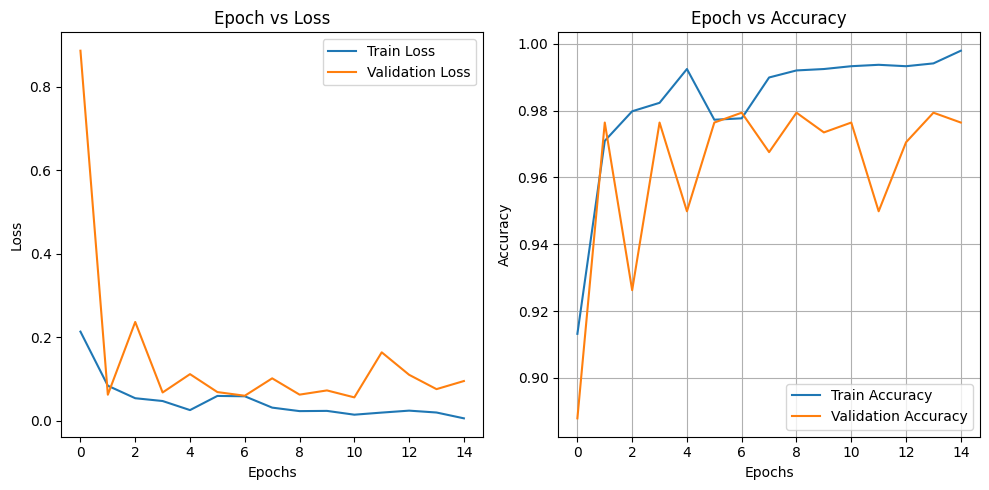

/var/tmp/ipykernel_26343/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|███████████████████████████| 22/22 [00:0


Test Metrics:
--------------------------------------------------
Loss      : 0.1088
Accuracy  : 0.9764
Precision : 0.8824
Recall    : 0.9813
True Negatives : 557
False Positives: 14
False Negatives: 2
True Positives : 105
F1 Score  : 0.9292
ROC AUC   : 0.9784
Metrics for class 0:
  Precision : 0.8824
  Recall    : 0.9813
  F1 Score  : 0.9292
  ROC AUC   : 0.9784
True Negatives : 557
False Positives: 14
False Negatives: 2
True Positives : 105
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       571
         1.0       0.88      0.98      0.93       107

    accuracy                           0.98       678
   macro avg       0.94      0.98      0.96       678
weighted avg       0.98      0.98      0.98       678

Total Misclassified Images: 16
Image Index: 9, Predicted Labels: [1.], True Labels: [0.]
Image Index: 66, Predicted Labels: [1.], True Labels: [0.]
Image Index: 180, Predicte

In [26]:
if __name__ == "__main__":
    num_classes=1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Model, Loss, and Optimizer
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Run the main function
    tvt(org_train_loader, org_val_loader, org_test_loader, model, criterion, optimizer, num_epochs=15)

In [53]:
from typing import Optional, Sequence
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(org_test_loader, "saved_model1.pt", criterion)

/var/tmp/ipykernel_26343/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|█████████████████████████████| 22/22 [00


Test Metrics:
--------------------------------------------------
Loss      : 0.0525
Accuracy  : 0.9882
Precision : 0.9369
Recall    : 0.9905
True Negatives : 566
False Positives: 7
False Negatives: 1
True Positives : 104
F1 Score  : 0.9630
ROC AUC   : 0.9891
Metrics for class 0:
  Precision : 0.9369
  Recall    : 0.9905
  F1 Score  : 0.9630
  ROC AUC   : 0.9891
True Negatives : 566
False Positives: 7
False Negatives: 1
True Positives : 104
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       573
         1.0       0.94      0.99      0.96       105

    accuracy                           0.99       678
   macro avg       0.97      0.99      0.98       678
weighted avg       0.99      0.99      0.99       678

Total Misclassified Images: 8


In [54]:
#function for all missclassified images

import matplotlib.pyplot as plt
import math

def show_misclassified_images(misclassified_images):
    num_images = len(misclassified_images)
    num_cols = 5  # Number of columns for the grid
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i in range(num_images):
        img_info = misclassified_images[i]
        img = img_info['image'].permute(1, 2, 0).numpy()  # Convert to HxWxC format and numpy array
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        index = img_info['image_index']  # Image index

        ax = axs[i // num_cols, i % num_cols]  # Determine subplot position
        ax.imshow(img)
        ax.set_title(f"Index: {index}\nPred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for i in range(num_images, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.tight_layout()
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.42

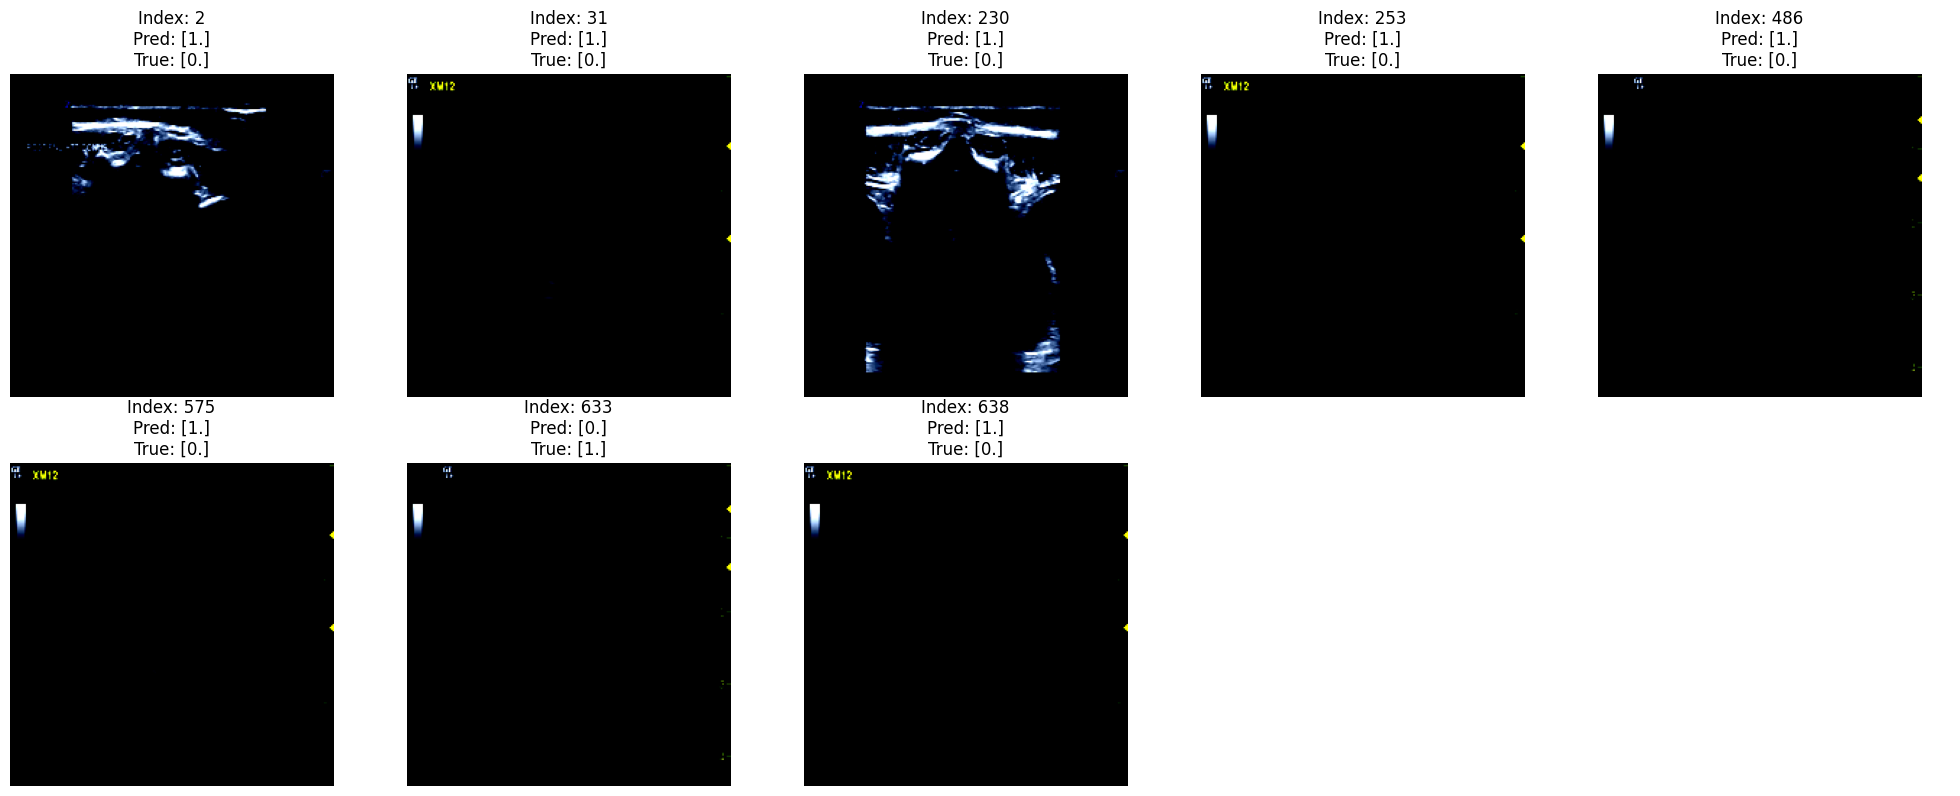

In [56]:
show_misclassified_images(misclassified_images)

# model two

In [88]:
# Define Custom Dataset
class CustomDataset_model_2(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'shortaxis_binary v2.xlsx')   #DSI_research/shortaxis_binary.xlsx
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=f'{video_folder}')
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/xxx_0.jpg
                        root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                        frame_idx = int(root.split('_')[-1]) #splitting xxx_0 and storing 0 to frame_idx
                        labels = labels_df.loc[frame_idx, ['CORD','FLUID']].values.astype('float32').squeeze()
                        if labels_df.at[frame_idx, 'BAD QUALITY'] == 0:
                            self.image_paths.append(img_path)
                            self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')   #DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/0.jpg_xxxxx.jpg
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['CORD','FLUID']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels


def initialize_data(root_dir, sub_folder, data_type='original'):
    # Define image transformations for training and validation/test
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop((224, 224)),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    # Initialize the dataset with training transformations
    full_dataset = CustomDataset_model_2(root_dir, sub_folder=sub_folder, transform=None, data_type=data_type)

    # Define the sizes for training, validation, and test sets
    total_size = len(full_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset into training, validation, and test sets
    train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply the appropriate transformations to each subset
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_subset.dataset.transform = val_test_transform

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    print('Data Size: train:', len(train_loader.dataset), 'val:', len(val_loader.dataset), 'test:', len(test_loader.dataset))

    return train_loader, val_loader, test_loader

In [99]:
# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)
# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})
            torch.save(model, "saved_model.pt")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the state of the model
        torch.save(model.state_dict(), "saved_model_state2.pt")
        torch.save(model, "saved_model2.pt")

        ######################### Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()
# Load Model
import io

# Assuming `model_data` is a byte stream (non-seekable) from a database or similar

def load_model(model_path):
    # Load the saved model
    model = torch.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

# Test Model
import io
def test_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            #Check for misclassifications
            for idx, (pred, true) in enumerate(zip(predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy(),
                        'image': images[idx].cpu().detach(),
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_true, y_pred)
        except:
            roc_auc = 1
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

# Main function to run the whole pipeline
def main(root_dir, sub_folder, model, criterion, optimizer, num_epochs, data_type='original'):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder, data_type=data_type)
    #check_loaders(train_loader, val_loader, test_loader)

    '''global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model2.pt", criterion)
    
import matplotlib.pyplot as plt

def show_images(images, labels=None, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axs[i].axis('off')
        if labels is not None:
            axs[i].set_title(labels[i])

def check_loaders(train_loader, val_loader, test_loader):
    print("Train Loader: {} batches ({} images)".format(len(train_loader), len(train_loader.dataset)))
    print("Validation Loader: {} batches ({} images)".format(len(val_loader), len(val_loader.dataset)))
    print("Test Loader: {} batches ({} images)".format(len(test_loader), len(test_loader.dataset)))

    # Optionally, visualize some images from each loader
    for images, labels in train_loader:
        show_images(images)
        break  # Just show the first batch
        
#train-valid-test
def tvt(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model2.pt", criterion)


Processing video folder: LP SONO 001 POST FNL CONUS
Processing video folder: US00000L
Processing video folder: AM12 (Converted)
Processing video folder: 01.09.31 hrs __0025097
Processing video folder: LPPILOTLAT1
Processing video folder: XM12 (Converted)
Processing video folder: LP SONO 001 POST FST CONUS
Processing video folder: LPPILOTSITTING2
Processing video folder: YM12 (Converted)
Processing video folder: 01.09.47 hrs __0025098
Processing video folder: LPPILOTLAT3
Processing video folder: LPPILOTLAT2
Processing video folder: BM12 (Converted)
Number of videos: 13
Data Size: train: 2010 val: 287 test: 575


Epoch 1: 100%|█████████████████████████| 63/63 [00:22<00:00,  2.77it/s, Batch Loss=0.0471, Batch Accuracy=0.981]


Epoch 1/15 - Loss: 0.1607, Accuracy: 0.9408
Validation:


Epoch 1: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.29it/s, Batch Loss=0.301, Batch Accuracy=0.887]


Validation Epoch 1/15 - Loss: 0.3086, Accuracy: 0.8693
------------------------------------------------------------------------------------------------


Epoch 2: 100%|████████████████████████████| 63/63 [00:22<00:00,  2.81it/s, Batch Loss=0.00904, Batch Accuracy=1]


Epoch 2/15 - Loss: 0.0523, Accuracy: 0.9833
Validation:


Epoch 2: 100%|████████████████████████████| 9/9 [00:01<00:00,  5.01it/s, Batch Loss=0.044, Batch Accuracy=0.984]


Validation Epoch 2/15 - Loss: 0.0565, Accuracy: 0.9826
------------------------------------------------------------------------------------------------


Epoch 3: 100%|█████████████████████████████| 63/63 [00:23<00:00,  2.69it/s, Batch Loss=0.0125, Batch Accuracy=1]


Epoch 3/15 - Loss: 0.0373, Accuracy: 0.9896
Validation:


Epoch 3: 100%|██████████████████████████████| 9/9 [00:01<00:00,  6.35it/s, Batch Loss=0.00344, Batch Accuracy=1]


Validation Epoch 3/15 - Loss: 0.0288, Accuracy: 0.9895
------------------------------------------------------------------------------------------------


Epoch 4: 100%|█████████████████████████| 63/63 [00:22<00:00,  2.80it/s, Batch Loss=0.0353, Batch Accuracy=0.981]


Epoch 4/15 - Loss: 0.0429, Accuracy: 0.9846
Validation:


Epoch 4: 100%|███████████████████████████| 9/9 [00:01<00:00,  6.40it/s, Batch Loss=0.0734, Batch Accuracy=0.952]


Validation Epoch 4/15 - Loss: 0.1023, Accuracy: 0.9617
------------------------------------------------------------------------------------------------


Epoch 5: 100%|████████████████████████████| 63/63 [00:23<00:00,  2.67it/s, Batch Loss=0.00495, Batch Accuracy=1]


Epoch 5/15 - Loss: 0.0331, Accuracy: 0.9910
Validation:


Epoch 5: 100%|███████████████████████████████| 9/9 [00:01<00:00,  6.43it/s, Batch Loss=0.0121, Batch Accuracy=1]


Validation Epoch 5/15 - Loss: 0.0295, Accuracy: 0.9878
------------------------------------------------------------------------------------------------


Epoch 6: 100%|█████████████████████████| 63/63 [00:22<00:00,  2.84it/s, Batch Loss=0.0724, Batch Accuracy=0.981]


Epoch 6/15 - Loss: 0.0121, Accuracy: 0.9973
Validation:


Epoch 6: 100%|██████████████████████████████| 9/9 [00:01<00:00,  6.27it/s, Batch Loss=0.00914, Batch Accuracy=1]


Validation Epoch 6/15 - Loss: 0.0400, Accuracy: 0.9878
------------------------------------------------------------------------------------------------


Epoch 7: 100%|██████████████████████████| 63/63 [00:23<00:00,  2.73it/s, Batch Loss=0.102, Batch Accuracy=0.962]


Epoch 7/15 - Loss: 0.0211, Accuracy: 0.9928
Validation:


Epoch 7: 100%|████████████████████████████| 9/9 [00:01<00:00,  5.30it/s, Batch Loss=0.266, Batch Accuracy=0.935]


Validation Epoch 7/15 - Loss: 0.1683, Accuracy: 0.9390
------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████████████████████| 63/63 [00:22<00:00,  2.80it/s, Batch Loss=0.115, Batch Accuracy=0.981]


Epoch 8/15 - Loss: 0.0237, Accuracy: 0.9935
Validation:


Epoch 8: 100%|██████████████████████████████| 9/9 [00:01<00:00,  6.40it/s, Batch Loss=0.00757, Batch Accuracy=1]


Validation Epoch 8/15 - Loss: 0.0118, Accuracy: 0.9948
------------------------------------------------------------------------------------------------


Epoch 9: 100%|████████████████████████████| 63/63 [00:22<00:00,  2.81it/s, Batch Loss=0.00423, Batch Accuracy=1]


Epoch 9/15 - Loss: 0.0127, Accuracy: 0.9960
Validation:


Epoch 9: 100%|██████████████████████████████| 9/9 [00:01<00:00,  6.46it/s, Batch Loss=0.00441, Batch Accuracy=1]


Validation Epoch 9/15 - Loss: 0.0082, Accuracy: 0.9965
------------------------------------------------------------------------------------------------


Epoch 10: 100%|███████████████████████████| 63/63 [00:23<00:00,  2.69it/s, Batch Loss=0.00198, Batch Accuracy=1]


Epoch 10/15 - Loss: 0.0089, Accuracy: 0.9975
Validation:


Epoch 10: 100%|█████████████████████████████| 9/9 [00:01<00:00,  6.43it/s, Batch Loss=0.00496, Batch Accuracy=1]


Validation Epoch 10/15 - Loss: 0.0167, Accuracy: 0.9930
------------------------------------------------------------------------------------------------


Epoch 11: 100%|██████████████████████████| 63/63 [00:22<00:00,  2.82it/s, Batch Loss=0.000876, Batch Accuracy=1]


Epoch 11/15 - Loss: 0.0059, Accuracy: 0.9980
Validation:


Epoch 11: 100%|█████████████████████████████| 9/9 [00:01<00:00,  6.31it/s, Batch Loss=0.00142, Batch Accuracy=1]


Validation Epoch 11/15 - Loss: 0.0097, Accuracy: 0.9965
------------------------------------------------------------------------------------------------


Epoch 12: 100%|██████████████████████████| 63/63 [00:23<00:00,  2.66it/s, Batch Loss=0.000306, Batch Accuracy=1]


Epoch 12/15 - Loss: 0.0029, Accuracy: 0.9990
Validation:


Epoch 12: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.44it/s, Batch Loss=0.000334, Batch Accuracy=1]


Validation Epoch 12/15 - Loss: 0.0204, Accuracy: 0.9948
------------------------------------------------------------------------------------------------


Epoch 13: 100%|████████████████████████████| 63/63 [00:22<00:00,  2.83it/s, Batch Loss=0.0031, Batch Accuracy=1]


Epoch 13/15 - Loss: 0.0023, Accuracy: 0.9993
Validation:


Epoch 13: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.37it/s, Batch Loss=0.000195, Batch Accuracy=1]


Validation Epoch 13/15 - Loss: 0.0167, Accuracy: 0.9965
------------------------------------------------------------------------------------------------


Epoch 14: 100%|██████████████████████████| 63/63 [00:22<00:00,  2.80it/s, Batch Loss=0.000859, Batch Accuracy=1]


Epoch 14/15 - Loss: 0.0035, Accuracy: 0.9998
Validation:


Epoch 14: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.20it/s, Batch Loss=0.000114, Batch Accuracy=1]


Validation Epoch 14/15 - Loss: 0.0135, Accuracy: 0.9965
------------------------------------------------------------------------------------------------


Epoch 15: 100%|██████████████████████████| 63/63 [00:23<00:00,  2.69it/s, Batch Loss=0.000547, Batch Accuracy=1]


Epoch 15/15 - Loss: 0.0010, Accuracy: 0.9998
Validation:


Epoch 15: 100%|████████████████████████████| 9/9 [00:01<00:00,  6.33it/s, Batch Loss=0.000106, Batch Accuracy=1]


Validation Epoch 15/15 - Loss: 0.0089, Accuracy: 0.9965
------------------------------------------------------------------------------------------------


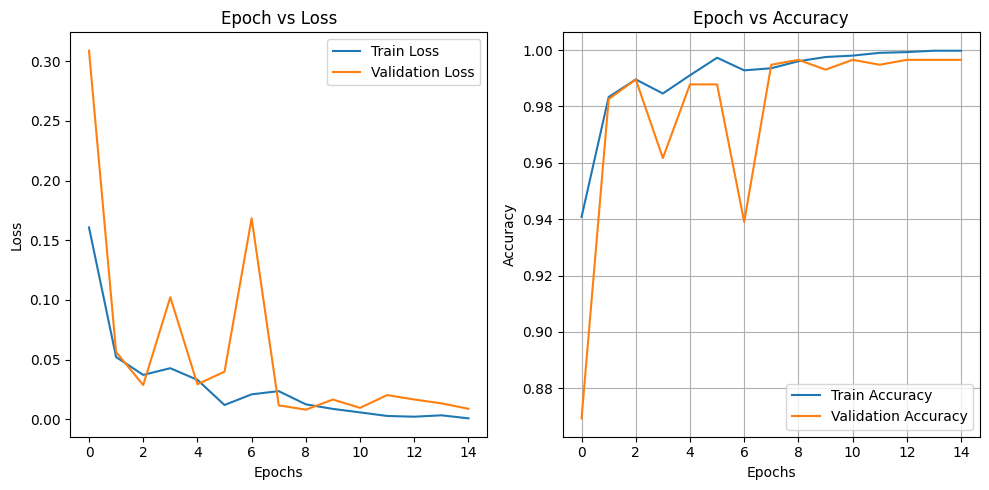

/var/tmp/ipykernel_26343/2560105889.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|██████████████████████████| 18/18 [00:


Test Metrics:
--------------------------------------------------
Loss      : 0.0356
Accuracy  : 0.9930
Precision : 0.9954
Recall    : 0.9923
True Negatives : 499
False Positives: 3
False Negatives: 5
True Positives : 643
F1 Score  : 0.9938
ROC AUC   : 0.9932
Metrics for class 0:
  Precision : 0.9929
  Recall    : 0.9859
  F1 Score  : 0.9894
  ROC AUC   : 0.9918
True Negatives : 432
False Positives: 1
False Negatives: 2
True Positives : 140
--------------------
Metrics for class 1:
  Precision : 0.9960
  Recall    : 0.9941
  F1 Score  : 0.9951
  ROC AUC   : 0.9825
True Negatives : 67
False Positives: 2
False Negatives: 3
True Positives : 503
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       142
           1       1.00      0.99      1.00       506

   micro avg       1.00      0.99      0.99       648
   macro avg       0.99      0.99      0.99       648
weighted avg       1.00   

In [94]:
root_dir = '.'
sub_folder = 'short axis frames'
num_classes=2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
org_train_loader, org_val_loader, org_test_loader = initialize_data(root_dir,
                                                                    sub_folder,
                                                                    data_type='original')
if __name__ == "__main__":
    num_classes=2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Model, Loss, and Optimizer
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Run the main function
    tvt(org_train_loader, org_val_loader, org_test_loader, model, criterion, optimizer, num_epochs=15)

In [100]:
from typing import Optional, Sequence
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(org_test_loader, "saved_model2.pt", criterion)

/var/tmp/ipykernel_26343/3231280995.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|██████████████████████████| 18/18 [00:


Test Metrics:
--------------------------------------------------
Loss      : 0.0356
Accuracy  : 0.9930
Precision : 0.9954
Recall    : 0.9923
True Negatives : 499
False Positives: 3
False Negatives: 5
True Positives : 643
F1 Score  : 0.9938
ROC AUC   : 0.9932
Metrics for class 0:
  Precision : 0.9929
  Recall    : 0.9859
  F1 Score  : 0.9894
  ROC AUC   : 0.9918
True Negatives : 432
False Positives: 1
False Negatives: 2
True Positives : 140
--------------------
Metrics for class 1:
  Precision : 0.9960
  Recall    : 0.9941
  F1 Score  : 0.9951
  ROC AUC   : 0.9825
True Negatives : 67
False Positives: 2
False Negatives: 3
True Positives : 503
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       142
           1       1.00      0.99      1.00       506

   micro avg       1.00      0.99      0.99       648
   macro avg       0.99      0.99      0.99       648
weighted avg       1.00   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.41

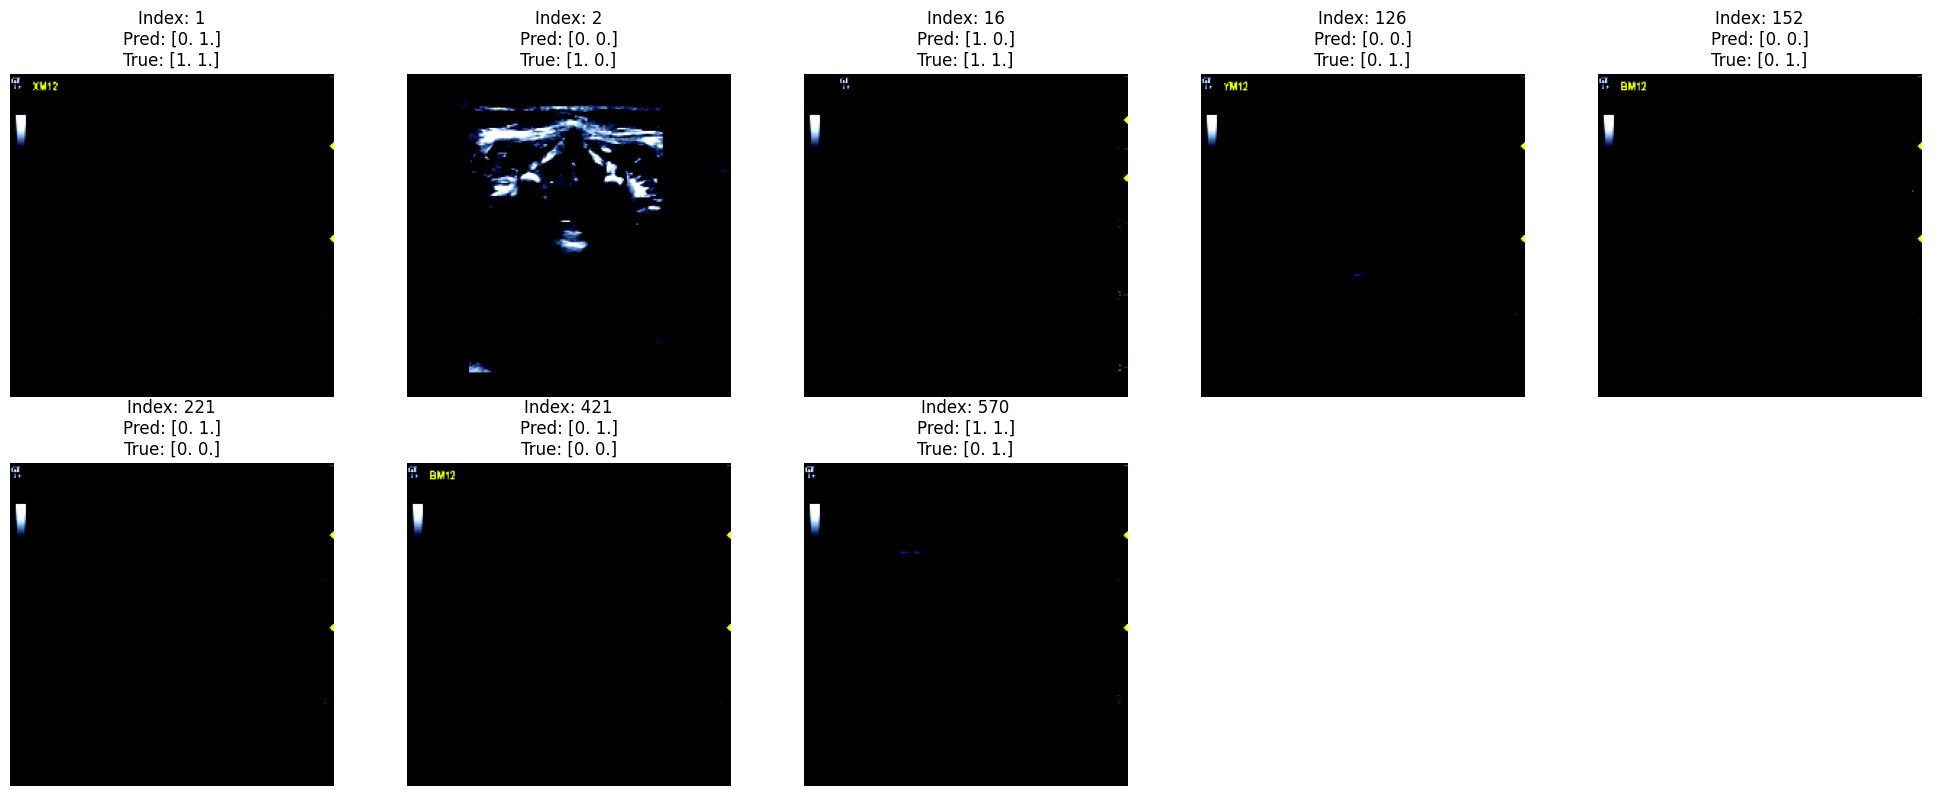

In [101]:
show_misclassified_images(misclassified_images)

In [111]:
# Define Custom Dataset
class CustomDataset_new(Dataset):
    def __init__(self, root_dir, transform, data_type='original'):
        self.root_dir = root_dir
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'new_image_labels.csv')   #DSI_research/shortaxis_binary.xlsx
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir)):
            if os.path.isdir(os.path.join(root_dir, video_folder)):
                video_path = os.path.join(root_dir, video_folder)   # DSI_research/video/AM12
                try:
                    labels_df = pd.read_csv(label_file)
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                
                for outer_folder in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    for img_filename in os.listdir(os.path.join(video_path,outer_folder)):
                        if img_filename.endswith(".jpg"):
                            img_path_orig = os.path.join(video_path,outer_folder, img_filename)   #dataset/AM12/xxx_0.jpg
                            drive = "/content/drive/MyDrive/"
                            img_path = os.path.join(drive, os.path.normpath(img_path_orig))
                            #root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                            labels = labels_df[labels_df['FILENAME'] == img_path][['CORD','FLUID']].values.astype('float32').squeeze()
                            if labels_df[labels_df['FILENAME'] == img_path]['BAD QUALITY'].values[0] == 0:
                                self.image_paths.append(img_path_orig)
                                self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')   #DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/0.jpg_xxxxx.jpg
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                        
                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels


# Initialize Dataset and Dataloader
def initialize_data(root_dir, data_type='original'):
    # Define image transformations

    
    # Define transformations for validation/test (without augmentation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    # Create the dataset with transformations
    test_dataset = CustomDataset_new(root_dir, transform=test_transform, data_type=data_type)


    # Create data loaders for each subset
    batch_size = 32
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    return test_loader

In [112]:
root_dir = root_dir = './New Image Frames LP Resized 434x532'
loader_test_new = initialize_data(root_dir,data_type='original')

Processing video folder: SPINAL CONUS
Processing video folder: FLUID positive examples
Processing video folder: SPINAL CORD positive examples and fluid positive too
Number of videos: 3


In [114]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(loader_test_new, "saved_model2.pt", criterion)

/var/tmp/ipykernel_26343/3231280995.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|████████████████████████████| 22/22 [0


Test Metrics:
--------------------------------------------------
Loss      : 1.2077
Accuracy  : 0.6791
Precision : 0.6641
Recall    : 0.8797
True Negatives : 245
False Positives: 344
False Negatives: 93
True Positives : 680
F1 Score  : 0.7568
ROC AUC   : 0.6478
Metrics for class 0:
  Precision : 0.4182
  Recall    : 0.9323
  F1 Score  : 0.5774
  ROC AUC   : 0.7115
True Negatives : 240
False Positives: 249
False Negatives: 13
True Positives : 179
--------------------
Metrics for class 1:
  Precision : 0.8406
  Recall    : 0.8623
  F1 Score  : 0.8513
  ROC AUC   : 0.4562
True Negatives : 5
False Positives: 95
False Negatives: 80
True Positives : 501
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.93      0.58       192
           1       0.84      0.86      0.85       581

   micro avg       0.66      0.88      0.76       773
   macro avg       0.63      0.90      0.71       773
weighted avg       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.5942485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.3850982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.8382572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.2805231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.2979523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.4025275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.1585187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.2108063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.5768193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.193377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.5942485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.2282355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.2630938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.454815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.3153814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.5593902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.4896734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.8556864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.5593902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.2108063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.3153814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.4896734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.1759479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.3850982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1

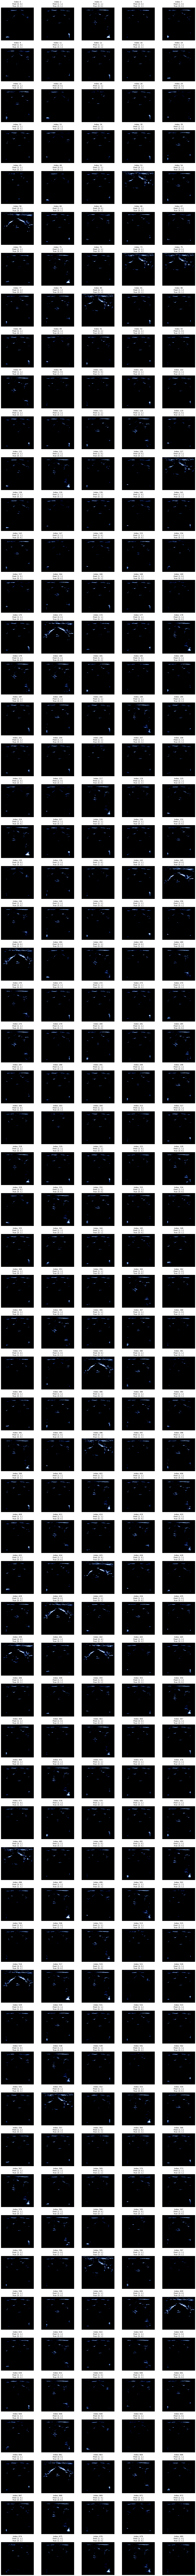

In [115]:
show_misclassified_images(misclassified_images)

In [ ]:
w